# Absorption depth of gamma-rays in the Galaxy

In [1]:
from pylab import *
import scipy.integrate
import scipy.interpolate

In [2]:
htagliatoC = 197.4 * 1e6 * 1e-13 #in eV cm
KB = 8.6 * 1e-5 #in eV K^-1
Relectron = 2.8179 * 10e-15 * 1e2 #in cm
htagliato = 6.58 * 1e-16 #in eV s
MassaE = 0.511 * 1e-6 #in TeV
MassaP = 938.27 * 1e-6 #in TeV
CaricaElettrone = 4.8 * 1e10 #in cm^(3/2) g^(1/2) s^-1
SigmaT = 6.65 * 1e-29 * 1e4 #in cm^2
kpctocm = 1e3 * 3.26 * 3.15 * 1e7 * 3.0 * 1e10

In [3]:
def xx1(Eg, ee, theta): 
    #ee in eV, Eg in GeV
    xx = 2 * Eg * ee * 1e-15 * ((1 - np.cos(theta)) / (4 * MassaE**2))
    return xx
vec_xx1 = np.vectorize(xx1)

In [4]:
def beta2(xx):
    if xx >= 1:
        beta = (1 - (1.0 / xx))**(0.5)
    if xx < 1:
        beta = 0
    return beta
vec_beta2 = np.vectorize(beta2)

In [5]:
def sigmaGG(beta):
    sigma = SigmaT * (3 / 16) * (1 - beta**2) * (2 * beta * (beta**2 - 2) + (3 - beta**4) * np.log((1 + beta) / (1 - beta)))
    return sigma
vec_sigmaGG = np.vectorize(sigmaGG)

[]

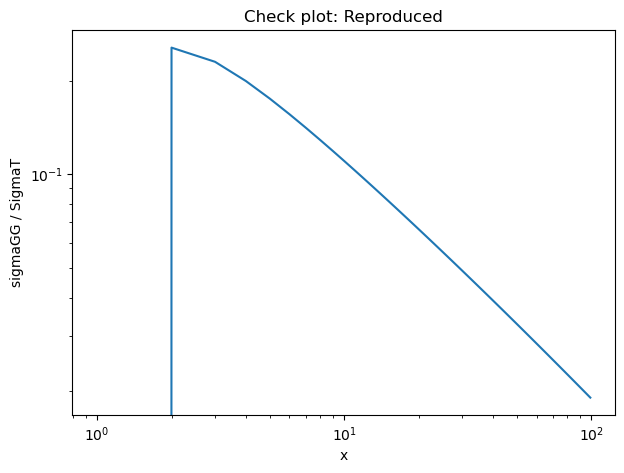

In [6]:
x = np.arange(1, 1e2)
x = x.astype(int)

plt.figure(figsize=(7, 5))
#plt.plot(x, vec_beta2(x), label='beta')
#plt.plot(x, vec_sigmaGG(vec_beta2(x)), label='sigmaGG')
#plt.legend()
plt.plot(x, vec_sigmaGG(vec_beta2(x)) / SigmaT)
plt.xlabel('x')
plt.ylabel('sigmaGG / SigmaT')
plt.title('Check plot: Reproduced')
plt.loglog()

In [7]:
def Ethr(ee, theta):
    E = 2 * MassaE / (ee * 1e-15 * (1 - np.cos(theta)))
    return E
vec_Ethr = np.vectorize(Ethr)

In [8]:
# Black body distribution
def n_bb(ee, T):
    n = (np.pi**2 * htagliatoC**3)**(-1) * (ee**2 / (np.exp(ee / (KB * T)) - 1))
    return n #in eV^(-1) cm^(-3)
vec_n_bb = np.vectorize(n_bb)

def n_bb_ee(ee, T):
    n = (np.pi**2 * htagliatoC**3)**(-1) * (ee**2 / (np.exp(ee / (KB * T)) - 1)) * ee
    return n #in cm^(-3)
vec_n_bb_ee = np.vectorize(n_bb_ee)

In [9]:
def EnergyDensityBB(T, nn):
    density = nn * scipy.integrate.quad(n_bb_ee, 0, 50 * KB * T, args=T) 
    return density #in eV cm^(-3)
vec_EnergyDensityBB = np.vectorize(EnergyDensityBB)

In [10]:
def integrand(ee, theta, T, Eg):
    integrand_value = np.sin(theta) * (1 - np.cos(theta)) * n_bb(ee, T) * sigmaGG(beta2(xx1(Eg, ee, theta)))
    return integrand_value
    
def KKProva(Eg, T):
    #integral = scipy.integrate.dblquad(integrand, 0, 500 * KB * T, 0, np.pi, args=(T, Eg))
    integral = scipy.integrate.dblquad(integrand, 0, np.pi, 0, 500 * KB * T, args=(T, Eg))
    KK = 2 * np.pi * kpctocm * integral[0]
    return KK #in kpc^(-1)
vec_KKProva = vectorize(KKProva)

logEg = np.arange(0, 7.07, 7/100)
Table = np.array((10**logEg, vec_KKProva(10**logEg, 2.7255)))
KK1 = scipy.interpolate.CubicSpline(Table[0,:], Table[1,:])

In [12]:
KK1(6)

array(8.26040541e-46)

def KK1(Eg):
    KK = KKProva(Eg, 2.7255)
    return KK
vec_KK1 = np.vectorize(KK1)

In [13]:
def tauABSiso(Eg, r):
    tau = KK1(Eg) * r / (4 * np.pi)
    return tau
vec_tauABSiso = np.vectorize(tauABSiso)

In [14]:
def tauABS(Eg, x1, x2):
    tau = scipy.integrate.quad(KK1, 0, np.abs(x2 - x1)) 
    return tau
vec_tauABS = np.vectorize(tauABS)

/var/folders/j4/1fvnmc755y74k9kgn5w7_s400000gn/T/ipykernel_10061/3106630669.py:8: RuntimeWarning: overflow encountered in exp
  n = (np.pi**2 * htagliatoC**3)**(-1) * (ee**2 / (np.exp(ee / (KB * T)) - 1)) * ee


Text(0.5, 1.0, 'Check plot: Reproduced')

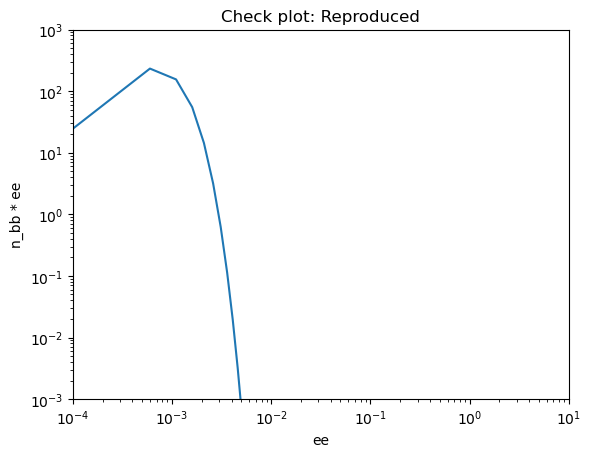

In [15]:
ee_plot = np.arange(1e-4, 10, 5e-4)

plt.plot(ee_plot, vec_n_bb_ee(ee_plot, 2.7))
plt.loglog()
plt.xlim(1e-4, 1e1)
plt.ylim(1e-3, 1e3)
plt.xlabel('ee')
plt.ylabel('n_bb * ee')
plt.title('Check plot: Reproduced')

Text(0.5, 1.0, 'Check plot: Reproduced')

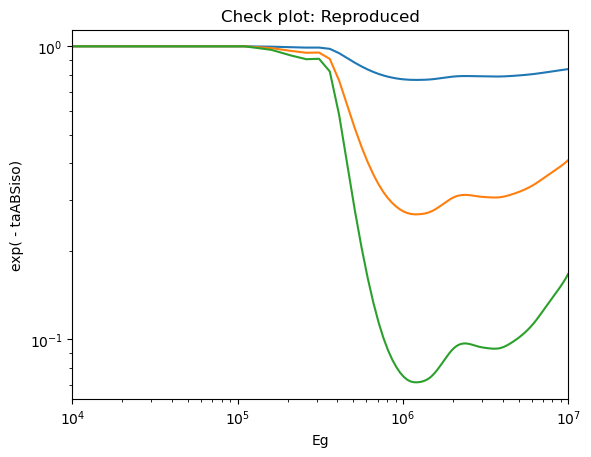

In [17]:
Eg_plot = np.arange(1e4,1e7, 5e4)

plt.plot(Eg_plot, np.exp(-vec_tauABSiso(Eg_plot, 2)))
plt.plot(Eg_plot, np.exp(-vec_tauABSiso(Eg_plot, 10)))
plt.plot(Eg_plot, np.exp(-vec_tauABSiso(Eg_plot, 20)))
plt.loglog()
plt.xlim(1e4, 1e7)
plt.xlabel('Eg')
plt.ylabel(r'exp( - taABSiso)')
plt.title('Check plot: Reproduced')

Text(0.5, 0, 'r')

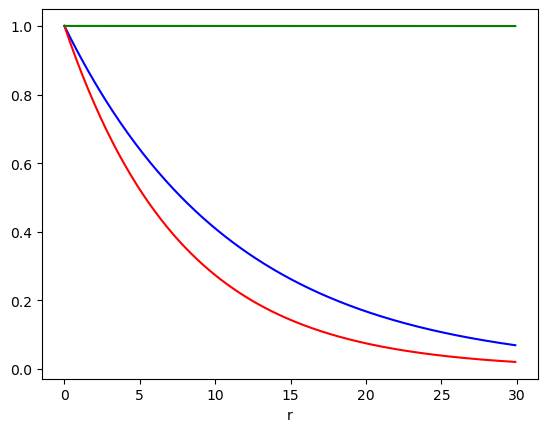

In [18]:
r_plot = np.arange(0, 30, 0.1)

plt.plot(r_plot, np.exp(-vec_tauABSiso(1e7, r_plot)), color='blue')
plt.plot(r_plot, np.exp(-vec_tauABSiso(1e6, r_plot)), color='red')
plt.plot(r_plot, np.exp(-vec_tauABSiso(1e5, r_plot)), color='green')
plt.xlabel('r')

/var/folders/j4/1fvnmc755y74k9kgn5w7_s400000gn/T/ipykernel_10061/211858073.py:7: RuntimeWarning: overflow encountered in exp
  plt.plot(Energy_gamma, np.exp(-tau))


[]

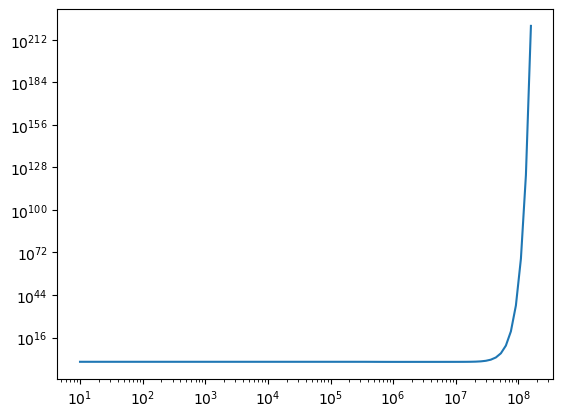

In [26]:
los = np.arange(0, 20, 0.1) #* 3.08567758128e21 # in cm
logE = np.arange(1., 9., (9. - 1.) / 100.)
Energy_gamma = 10**logE
tau = vec_tauABSiso(Energy_gamma, los[10])


plt.plot(Energy_gamma, np.exp(-tau))
plt.loglog()